In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import ivac
import pyemma
import sys

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data

In [4]:
# use feature 2, based on what looked best for Rong's MSM
data_trajs = np.load("../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
print(len(data_trajs), data_trajs[0].shape)

237 (10000, 60)


In [5]:
import pickle

In [6]:
# TICA/IVAC to reduce dimensionality
with open("../data/livac-feat2-anton.pkl", mode="rb") as f:
    livac = pickle.load(f)

In [7]:
# definitely appears to be a gap near 7 or 10 eigenvalues
# take the top 10 eigenvectors
ivac_trajs = np.load("../data/feat2_anton_ivac.npy", allow_pickle=True)
print(len(ivac_trajs), ivac_trajs[0].shape)

237 (10000, 10)


In [8]:
dtrajs = np.load("../data/raw_feat/feat2_ind500_anton.npy")

In [9]:
# split into individual trajectories
orig_traj_lens = [len(traj) for traj in data_trajs]
orig_traj_inds = []
subtot = 0
for length in orig_traj_lens[:-1]:
    subtot += length
    orig_traj_inds.append(subtot)
dtrajs = np.split(dtrajs, orig_traj_inds)
print(len(dtrajs))

237


In [10]:
len(dtrajs[0])

10000

# Transition matrices

In [11]:
# compute the transition matrix at a bunch of time points
models = []
max_lag = 1000  # in number of MD steps (*0.1 ns)
step = 10
nstates = 500
T_list = np.empty((max_lag // 10, nstates, nstates))

# start from lag 10 up to lag 1000
for lag in range(step, max_lag + step, step):
    if lag % 100 == 0:
        print(f"Calculating transition matrices for lag {lag}")
    T = pyemma.msm.estimate_markov_model(dtrajs, lag, reversible=True)
    models.append(T)
    T_list[lag // 10 - 1] = T.transition_matrix

Calculating transition matrices for lag 100
Calculating transition matrices for lag 200
Calculating transition matrices for lag 300
Calculating transition matrices for lag 400
Calculating transition matrices for lag 500
Calculating transition matrices for lag 600
Calculating transition matrices for lag 700
Calculating transition matrices for lag 800
Calculating transition matrices for lag 900
Calculating transition matrices for lag 1000


In [12]:
print(len(models))

100


## Reduce number of states with PCCA 

In [13]:
ck = models[0].cktest(7)

(<Figure size 504x504 with 49 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
   

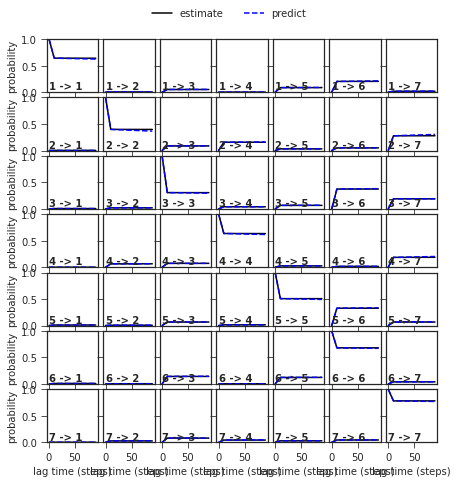

In [15]:
pyemma.plots.plot_cktest(ck, figsize=(7, 7))

In [14]:
pyemma.msm.ChapmanKolmogorovValidator(models[0], ck)

TypeError: __init__() missing 1 required positional argument: 'memberships'

In [28]:
models[0].metastable_distributions.shape

(7, 500)

Estimate MSM at lag of 5000

In [29]:
msm5000 = pyemma.msm.estimate_markov_model(dtrajs, 5000, reversible=True)

In [30]:
ck5000 = msm5000.cktest(7, n_jobs=4)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 205 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 200 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 189 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 184 components
  warnings.warn('truncated 

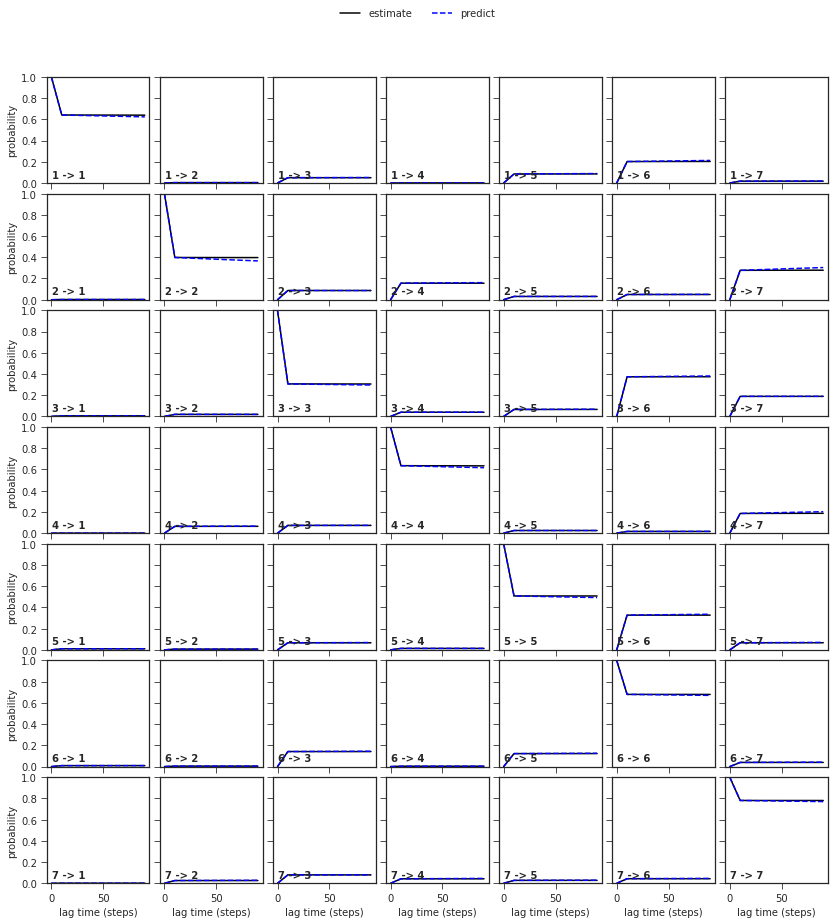

In [31]:
f, axes = pyemma.plots.plot_cktest(ck, figsize=(14, 14))

In [32]:
pcca = msm5000.pcca(7)
coarse_T = pcca.coarse_grained_transition_matrix

In [33]:
coarse_T

array([[ 9.99460688e-01,  1.51027257e-04,  5.58574817e-06,
         1.81443074e-04,  1.52664919e-05,  4.14309209e-05,
         1.44558856e-04],
       [ 5.38624108e-05,  9.91474377e-01, -1.47275273e-05,
         4.21905005e-03,  4.71606294e-04,  8.75440400e-04,
         2.92039184e-03],
       [-1.78697464e-07,  2.01567089e-06,  9.94870689e-01,
         8.04236082e-06,  5.15055503e-03, -1.72867481e-05,
        -1.38369686e-05],
       [ 2.63540228e-06,  1.70970058e-04,  1.34211197e-05,
         9.95149986e-01,  2.60824563e-04,  2.96167652e-03,
         1.44048660e-03],
       [ 3.40495144e-07,  2.37635124e-05,  1.30664005e-03,
         2.77967580e-04,  9.98219218e-01,  8.81347640e-05,
         8.39355402e-05],
       [ 7.81464628e-07,  5.46425738e-05,  1.72925009e-05,
         2.53630225e-03,  7.67140825e-05,  9.96903285e-01,
         4.10982355e-04],
       [ 6.78579639e-07,  4.56268604e-05,  1.83097986e-05,
         4.49779723e-04,  6.59805716e-06,  1.10883717e-04,
         9.9936812

In [34]:
coarse_T0 = models[0].pcca(7).coarse_grained_transition_matrix

In [35]:
coarse_T0

array([[ 9.96482936e-01,  3.17833974e-05,  2.26807695e-04,
        -9.84759170e-06,  9.70624167e-04,  2.24941327e-03,
         4.82834765e-05],
       [-3.21300418e-06,  9.88264794e-01,  6.34071318e-04,
         2.89768042e-03,  1.48134118e-05, -7.05966685e-04,
         8.89782026e-03],
       [-2.21778407e-05,  6.38839504e-05,  9.92616414e-01,
        -4.00891813e-06, -5.98700422e-05,  7.62025217e-03,
        -2.14493014e-04],
       [-2.79946669e-06,  1.40137391e-03,  6.05307004e-04,
         9.95638030e-01,  3.13377514e-05, -6.94888186e-04,
         3.02163937e-03],
       [ 1.17613224e-04,  1.54086536e-05,  1.06033096e-04,
        -2.77527846e-05,  9.95237716e-01,  3.77929092e-03,
         7.71690721e-04],
       [ 1.16474514e-04,  2.50827323e-05,  2.04114632e-03,
        -1.42148258e-05,  1.44278710e-03,  9.95967762e-01,
         4.20962174e-04],
       [ 6.27882263e-06,  7.14874367e-04,  5.87509379e-04,
         7.52828908e-04,  3.40871856e-04, -1.85408132e-04,
         9.9778304

## Compute all transition matrices

In [37]:
coarse_T = np.empty((len(models), 7, 7))
for i, msm in enumerate(models):
    if i % 10 == 0:
        print(f"Computing {i}th coarse grained transition matrix")
    coarse_T[i] = msm.pcca(7).coarse_grained_transition_matrix

Computing 0th coarse grained transition matrix
Computing 10th coarse grained transition matrix
Computing 20th coarse grained transition matrix
Computing 30th coarse grained transition matrix
Computing 40th coarse grained transition matrix
Computing 50th coarse grained transition matrix
Computing 60th coarse grained transition matrix
Computing 70th coarse grained transition matrix
Computing 80th coarse grained transition matrix
Computing 90th coarse grained transition matrix


# Kernel

In [38]:
def compute_kernel(T_list):
    # compute the kernel at all time points
    K_list = np.zeros_like(T_list)
    # forward finite difference for derivative
    T_dots = T_list[1:] - T_list[:-1]

    # first element of memory kernel
    # T(0) = 1
    nstates = T_list.shape[1]
    T_dot_0 = T_list[0] - np.eye(nstates)
    K1 = T_dots[0] - T_dot_0 @ T_list[0]
    K_list[0] = K1

    for n in range(1, len(T_list) - 1):
        if n % 100 == 0:
            print(f"Finished computing kernel {n}")
        conv = np.zeros_like(K1)
        for m in range(0, n):
            # K is not defined at time 0
            conv += K_list[m] @ T_list[n - m - 1]
        K = (T_dots[n] - T_dot_0 @ T_list[n]) - conv
        K_list[n] = K

    return K_list

In [39]:
K_all = compute_kernel(coarse_T)

In [40]:
K_all.shape

(100, 7, 7)

## Evaluate kernal decay with MIK

In [41]:
def MIK(kernels):
    N = kernels.shape[1]
    running_sum = np.einsum("ijk->i", np.cumsum(kernels, axis=0) ** 2)
    return np.sqrt(running_sum) / N

In [42]:
mik = MIK(K_all)

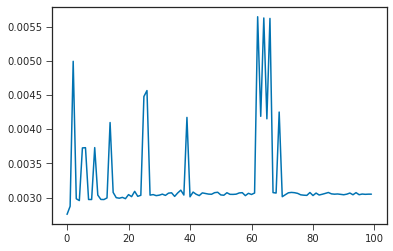

In [43]:
plt.plot(mik)

# Try fitting transition matrices first

See Unarta et al. PNAS 2021

In [44]:
from scipy import linalg

In [46]:
evals, V_all = np.linalg.eig(coarse_T)

In [47]:
evals.shape

(100, 7)

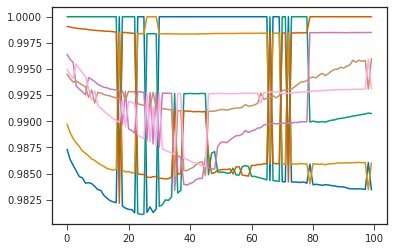

In [49]:
for i in range(7):
    plt.plot(evals[:, i], "-")